In [108]:
%matplotlib widget
from gekko import GEKKO
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt
import requests
plt.ion()

#For Video Export

# Make an MP4 animation?
make_mp4 = True
if make_mp4:
    import imageio  # required to make animation
    import os
    try:
        os.mkdir('./figures')
    except:
        pass

# Get CO2 Data

request url: https://api.energidataservice.dk/dataset/CO2EmisProg?start=2024-01-01T00%3A00&end=2024-01-17T00%3A00&filter=%7B%22PriceArea%22%3A%5B%22DK2%22%5D%7D&sort=Minutes5UTC+ASC
status code: 200



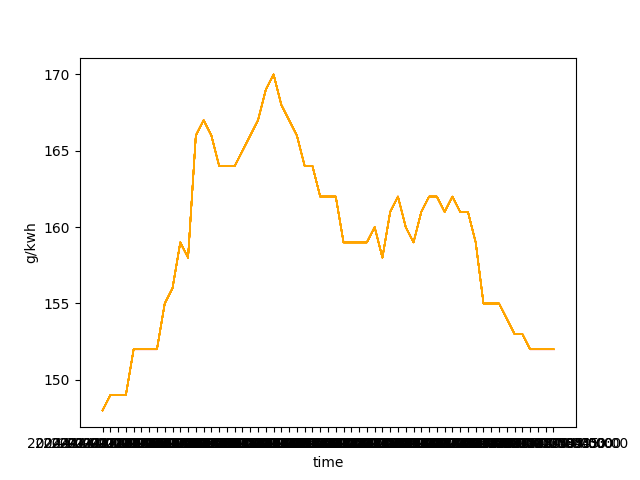

In [109]:
# Get CO2 Data
response = requests.get(url='https://api.energidataservice.dk/dataset/CO2EmisProg', params={"start": "2024-01-01T00:00","end":"2024-01-17T00:00","filter":"{\"PriceArea\":[\"DK2\"]}","sort":"Minutes5UTC ASC"})
print(f"request url: {response.request.url}")
print(f"status code: {response.status_code}", end="\n\n")

if response.ok:
	result = response.json()
	df_co2 = pd.DataFrame(result["records"])	
else:
	df_co2 = pd.DataFrame()
	raise f"Returned status {response.status_code}: {response.text}"

plt.figure("co2")
plt.plot(df_co2["Minutes5DK"][0:59].values,df_co2["CO2Emission"][0:59].values,color='orange',linewidth=1)

plt.xlabel('time')
plt.ylabel('g/kwh')
#plt.legend()
plt.show()  


# Inflow Estimation

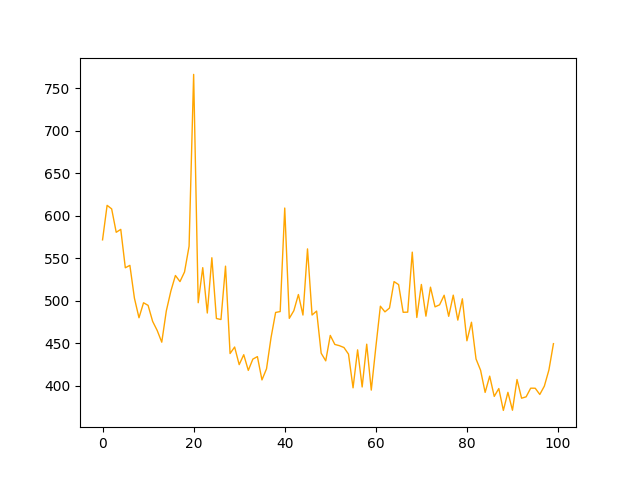

In [110]:

df_Qin = pd.read_pickle("../data/pump_station_data_estimated.pkl")    
#df_Qin = pd.Series(df_Qin[0][1200:], name="Qin_hat")
Qin_v = df_Qin[0][1200::1000].values
plt.figure()
plt.plot(Qin_v[:100],color='orange',linewidth=1)


# Setup the MPC

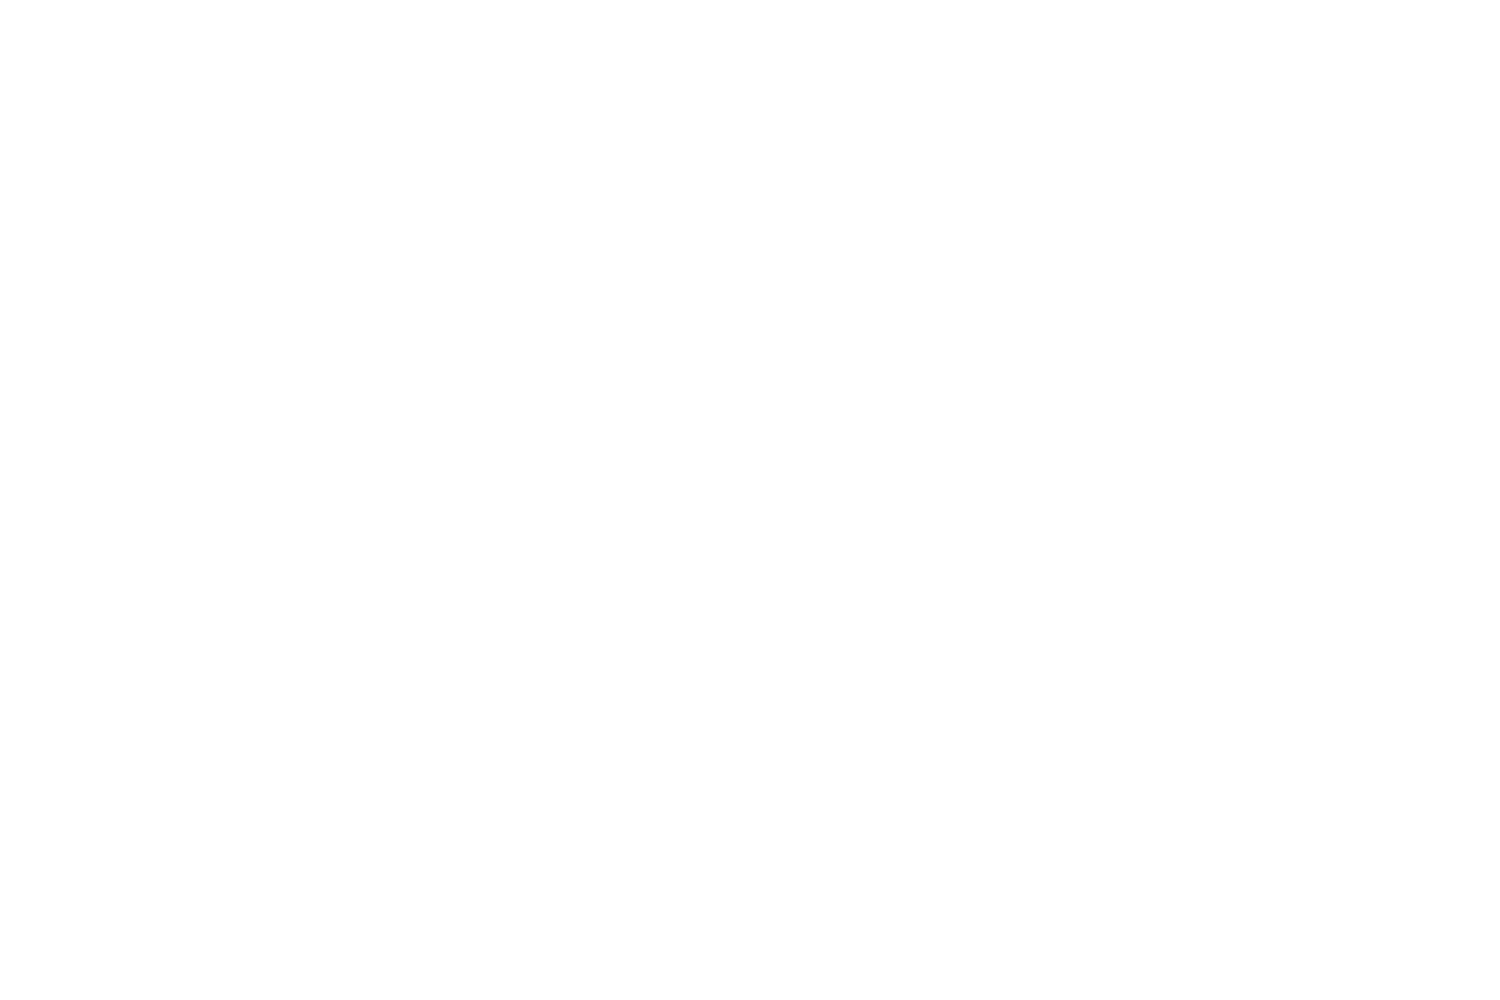

Solved 1/20 in 2.0785s
Solved 2/20 in 1.1292s


KeyboardInterrupt: 

In [111]:
h_hist = []
w_hist = []
Qout_hist = []
Qin_hist = []
P_hist = []
c_hist = []

m = GEKKO(remote=False)
m.options.SOLVER = 1 # APOPT solver
#m.options.DIAGLEVEL=1
m.TIME_SHIFT = 1

#time horizon: 6h
Thor = int(1*60) #sec
Ts = 1 #sec
n = Ts*Thor
m.time = np.linspace(0,int(Thor-1),n)

# Manipulated variable
w = m.MV(value=0, lb = 0, ub = 1500,integer=False)
w.STATUS = 1  # allow optimizer to change
w.DCOST = 0.05 # smooth out gas pedal movement
#w.DMAX = 20   # slow down change of gas pedal
#m.free_initial(w)

# Controlled Variable
Qout = m.CV(value=0)
P = m.CV(value=0)
h = m.CV(value=200)
#m.options.CV_TYPE = 2 # squared error



m.options.CV_TYPE = 1 # Linear error with deadband
eH = m.CV(value=0)
eH.SPHI=0         #Set point high for linear error model.
eH.WSPHI=10000    #Objective function weight on upper set point for linear error model.
eH.WSPLO=0        # Objective function weight on lower set point for linear error model
eH.STATUS =1      # eH : Error is considered in the objective function.

eL = m.CV(value=0)
eL.SPLO=0
eL.WSPHI=10     # key weight influencing attraction to lower levels
eL.WSPLO=0
eL.STATUS = 1    

# CO2 Values
#co2 = np.random.randint(70,100,size=n)
#x_values = np.linspace(0, 2 * np.pi, n)
x_values = np.linspace(0, 3 * np.pi, n)
y_values = np.sin(x_values)*30
noise_factor = 1
co2 = y_values + noise_factor * np.random.normal(size=len(y_values))+60

c = m.Param(value=co2)
m.Minimize(c*P)

Qin = m.Param(value=Qin_v[0])


# Process model
A_power = np.array([[3.7971E-01],\
                    [5.1151E-02],\
                    [3.1656E-01]])
A_outflow = np.array([[1.2995],\
                    [-4.3918E-01],\
                    [4.5231E-02],\
                    [0],\
                    [1.0387E-02]])

# B (ny x (nb x nu))
B_power = np.array([[[5.5404E-02],[-1.4118E-02],[-2.3452E-02]]]).T
B_outflow = np.array([[[7.1049E-02],[4.1327E-02],[6.4801E-02],[0],[-6.6199E-02]]]).T

# C_power = np.array([-6.6831])
# C_outflow = np.array([-7.3292E+01])

C_power = np.array([0])
C_outflow = np.array([0])

p_power = {'a':A_power,'b':B_power,'c':C_power}
p_outflow = {'a':A_outflow,'b':B_outflow,'c':C_outflow}

# Qout = m.if3(w-750,0,Qout)


m.arx(p_power,P,w)
m.arx(p_outflow,Qout,w)

#P = m.if3(w-750,0,P_c)
#Qout = m.if3(w-750,0,Qout_c)


m.Equation(h.dt() == 1/18 *(Qin - Qout)/3600*100)
#m.Equation(h.dt() == 1/18 *(75 - m.if3(w-750,0,Qout))/3600*100)
dh = m.Var()
m.Equation(h.dt() == dh*100)
m.Equations([eH==h-200,eL==h-120]) # Errors

m.options.IMODE = 6 # control

#m.solve(disp=False)


plt.figure(figsize=(15,10))
plt.show()
#plt.figure(3)

#c.value = df_co2["CO2Emission"][0:n]
#m.solve(disp=False)

tm = []
simtime = 20
for i in range(0,simtime):


    # Set CO2 Prognosis
    c.value = df_co2["CO2Emission"][i:i+n]

    
    m.solve(disp=False)
    print(f"Solved {i+1}/{simtime} in {m.options.SOLVETIME}s")
    # Set Initialize RPM to previos value
    w.MEAS = w.NEWVAL
    Qin.VALUE = Qin_v[i]

    # Appending to History
    w_hist.append(w.VALUE[0])
    h_hist.append(h.VALUE[0])
    Qout_hist.append(Qout.VALUE[0])
    Qin_hist.append(Qin_v[i])
    P_hist.append(P.VALUE[0])
    c_hist.append(c.VALUE[0])
    tm.append(i)
    # ------- Plotting -------------
    

    plt.clf()    
    ax1 = plt.subplot(4,1,1)
    plt.title("Moving Horizon MPC")
    ax1.grid()
    plt.plot(m.time+i,w.Value,"k--",label='Pump Speed (Pred.)')
    plt.plot(tm,w_hist,"kx-",label='Pump Speed (Meas.)')
    plt.plot([i,i],[ax1.get_ylim()[0],ax1.get_ylim()[1]],'k-',lw=1)
    plt.legend(loc=5)
    plt.ylabel('Speed [RPM]')

    ax2 = plt.subplot(4,1,2, sharex=ax1)
    plt.plot(m.time+i,h.Value,"k--",label='Water Level (Pred.)')
    plt.plot(tm,h_hist,"kx-",label='Water Level (Meas.)')
    plt.plot([i,i],[ax2.get_ylim()[0],ax2.get_ylim()[1]],'k-',lw=1)
    plt.legend(loc=5)
    plt.ylabel('Level [m]')

    ax3 = plt.subplot(4,1,3, sharex=ax1)
    plt.plot(m.time+i,Qout.Value,"r--",label='Outflow (Pred.)')
    plt.plot([(m.time+i)[0],(m.time+i)[-1]],[Qin_v[i], Qin_v[i]],"b--",label='Inflow (Pred.)')
    plt.plot(tm,Qout_hist,"rx-",label='Outflow (Meas.)')
    plt.plot(tm,Qin_hist,"bx-",label='Inflow (Est.)')
    plt.plot([i,i],[ax3.get_ylim()[0],ax3.get_ylim()[1]],'k-',lw=1)
    plt.legend(loc=5)
    plt.ylabel('Flow Rate [m^3/h]')

    ax4 = plt.subplot(4,1,4, sharex=ax1)
    plt.plot(m.time+i,c.Value,"k--")
    plt.plot(tm,c_hist,"kx-") 
    plt.plot([i,i],[ax4.get_ylim()[0],ax4.get_ylim()[1]],'k-',lw=1)
    plt.ylabel('CO2 Emission Prog. [g/kwh]')
    plt.xlabel('Time [s]')

    plt.draw()

    if make_mp4:
        filename='./figures/plot_'+str(i+10000)+'.png'
        plt.savefig(filename)

    #plt.pause(0.05)
    # ax1 = plt.subplot(4,1,1)
    # plt.plot(m.time+i,w.Value)
    # plt.subplot(4,1,2, sharex=ax1)
    # plt.plot(m.time+i,h.Value)
    # plt.subplot(4,1,3, sharex=ax1)
    # plt.plot(m.time+i,c.Value)
    # plt.subplot(4,1,4, sharex=ax1)
    # plt.scatter(i, Qin.VALUE,marker="x")
    # plt.plot(m.time+i,Qout.Value)


    
    # Save new Pumpspeed
    #w_hist.append(w.NEWVAL)
    


# generate mp4 from png figures in batches of 350
if make_mp4:

    path = "./figures/plot"   
    fileList = []
    for i in range(0,simtime-1):
        complete_path = f"{path}_{i+10000}.png"
        fileList.append(complete_path)

    writer = imageio.get_writer('results.mp4', fps=2)
    for im in fileList:
        writer.append_data(imageio.imread(im))
    writer.close()

    # images = []
    # iset = 0
    # for i in range(1,simtime-1):
    #     filename='./figures/plot_'+str(i+10000)+'.png'
    #     images.append(imageio.imread(filename))
    #     if ((i+1)%350)==0:
    #         imageio.mimsave('results_'+str(iset)+'.mp4', images)
    #         iset += 1
    #         images = []
    # if images!=[]:
    #     imageio.mimsave('results_'+str(iset)+'.mp4', images)


The emitted CO2 is 49.32424883148044 g


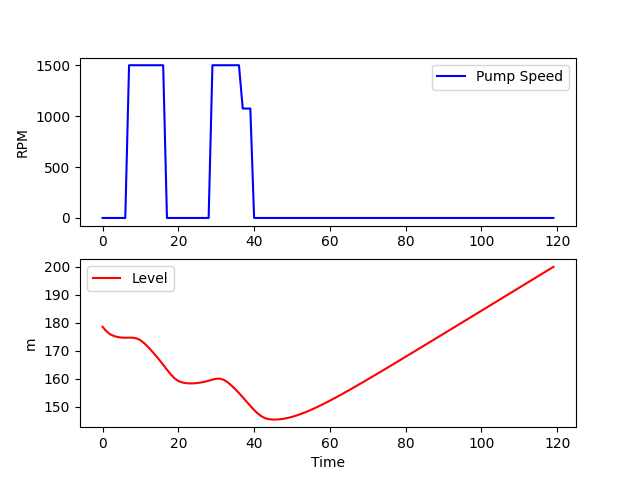

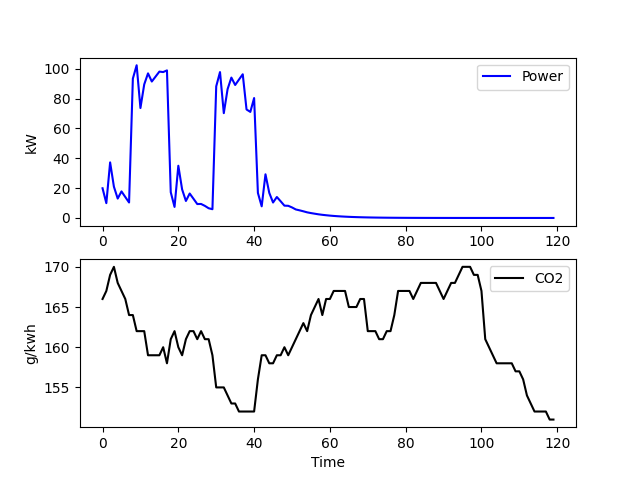

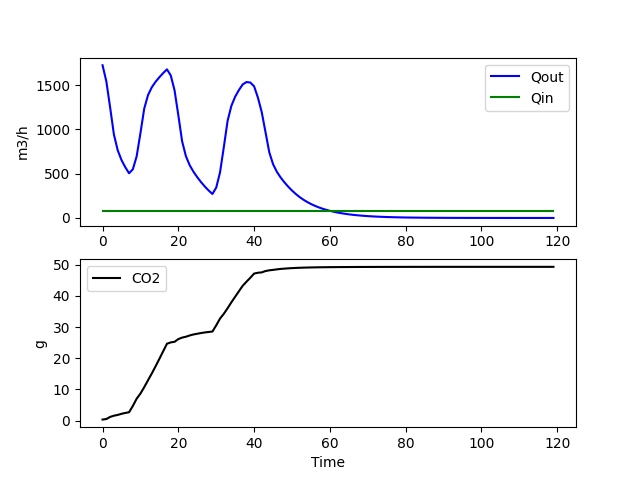

In [ ]:

# get additional solution information
import json
with open(m.path+'//results.json') as f:
    results = json.load(f)


#Calculate the costs.
emission = 0
cost_list = []
for i in range(0,len(P)):
    emission = emission + co2[i]/3600*P[i]*Ts
    cost_list.append(emission)
print('The emitted CO2 is' ,emission, 'g') 

plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(m.time,w.value,'b-',label='Pump Speed')
plt.legend()
plt.ylabel('RPM')
plt.subplot(2,1,2, sharex=ax1)
#plt.plot(m.time,results['v3.sp'],'k-',label='Reference Trajectory')
plt.plot(m.time,h.value,'r-',label='Level')
plt.ylabel('m')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1, sharex=ax1)
plt.plot(m.time,P.value,'b-',label='Power')
plt.legend()
plt.ylabel('kW')
plt.subplot(2,1,2, sharex=ax1)
plt.plot(m.time,c.Value,'k-',label='CO2')
plt.ylabel('g/kwh')
plt.xlabel('Time')
plt.legend(loc='best')

plt.figure()
plt.subplot(2,1,1, sharex=ax1)
plt.plot(m.time,Qout.value,'b-',label='Qout')
plt.plot(m.time,75*np.ones(n),'g-',label='Qin')
plt.legend()
plt.ylabel('m3/h')
plt.subplot(2,1,2, sharex=ax1)
plt.plot(m.time,cost_list,'k-',label='CO2')
plt.ylabel('g')
plt.xlabel('Time')
plt.legend(loc='best')
